## Предобработка

In [635]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import math
import scipy.stats
import  statistics

from sklearn import neighbors
from sklearn.linear_model import LinearRegression

In [636]:
df=pd.read_csv("Тестовое задание_dataframe.csv", names=['split'], encoding='latin-1')
df1 = pd.DataFrame.from_records(df, columns=['split'])

In [637]:
# Достаем данные из csv файла
new_df = df1['split'][1:].str.split(';',expand=True)
df = new_df.rename(columns={0: 'Time', 1: 'Sm'})
df

,Time,Sm
1,27.07.2022 15:15,718
2,27.07.2022 15:30,665
3,27.07.2022 15:45,637
4,27.07.2022 16:00,661
5,27.07.2022 16:15,668
...,...,...
2877,26.08.2022 14:15,793
2878,26.08.2022 14:30,706
2879,26.08.2022 14:45,556
2880,26.08.2022 15:00,582


In [638]:
# Удаляем все пустые поля, ибо информации они не несут
df = df.drop(labels = (df[df['Sm'] == ''].index) ,axis = 0)
df.index = np.arange(1, len(df) + 1)

In [639]:
df['Sm'] = df['Sm'].astype(int)
df.sort_values('Time')

,Time,Sm
391,01.08.2022 0:00,1
392,01.08.2022 0:15,2
393,01.08.2022 0:30,3
394,01.08.2022 0:45,1
430,01.08.2022 10:00,521
...,...,...
331,31.07.2022 8:45,267
332,31.07.2022 9:00,245
333,31.07.2022 9:15,308
334,31.07.2022 9:30,370


In [640]:
# Следом я применяю следующий подход:
# можно заметить, что временной ряд фикисирует метрику каждые пятнадцать минут
# для удобство можно заменить эту величины на среднее значение по за час
# это позволит нам убрать избыток данных
arr, dates = [], []
date = df['Time'][1]
counter = 0
c, amount = 1, df['Sm'][1]
for i in range(2,len(df['Time'])):
    #print(df['Time'][i][0:2],date)
    ti = df['Time'][i]
    if ti[len(ti)-2:] != date[len(date)-2:]:
        c = c + 1
        amount = amount + df['Sm'][i]
    else:
        arr.append(amount/c)
        dates.append(date)
        counter = counter + 1
        #print(c)
        date = df['Time'][i]
        c, amount = 1, df['Sm'][i]
arr.append(amount/c)
dates.append(date)
        

In [644]:
df1 = pd.DataFrame()
df1['Time'] = dates
df1['Sm']   = arr

mx = max(df1['Sm'])
mi = min(df1['Sm'])
h  = mx - mi
x_ =  statistics.mean(df1['Sm'])
d_ =  statistics.pvariance(df1['Sm'])
print("Мин  значение в выборке:   ",mx)
print("Макс значение в выборке:   ",mi)
print("Размах выборки:            ",h)
print("Выборочное среднее выборки:",x_)
print("Выборочная дисперися      :",d_)

Мин  значение в выборке:    831.5
Макс значение в выборке:    1.0
Размах выборки:             830.5
Выборочное среднее выборки: 364.915625433847
Выборочная дисперися      : 85782.96970107367


686


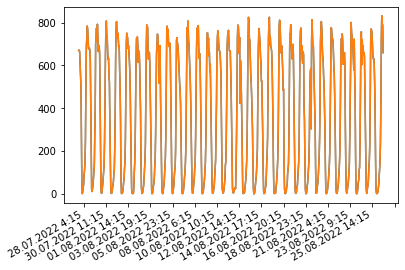

In [645]:
# Посмотрим на график имещющегося у нас временного ряда 

plt.plot(df1.Sm)

print(len(dates))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
plt.plot(dates,df1.Sm)
plt.gcf().autofmt_xdate()
plt.show()


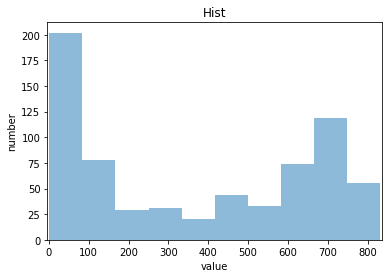

In [652]:
# Гистограмма распределения значений по формуле Стерджиса
# Уже из графика видим, что распределение явно не нормальное

# Заметим, что гистограмму мы строили по интервальному ряду,
# ибо это имеет больше смысла

bins = np.linspace(math.ceil(min(df1.Sm)), 
                   math.floor(max(df1.Sm)),
                   math.ceil(math.log(len(df1.Sm),2)+1)) # fixed number of bins


plt.xlim([min(df1.Sm)-5, max(df1.Sm)+5])
plt.hist(df1.Sm, bins=bins, alpha=0.5)

plt.title('Hist')
plt.xlabel('value')
plt.ylabel('number')
plt.show()

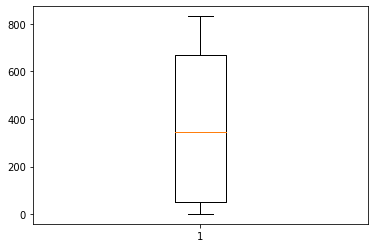

In [653]:
# Так же для визуализации построим коробочку с усиками
# В сущности она повторяет то, что мы узнали ранее.
# Так, например, выборочное среднее находится в районе 400
plt.boxplot(df1.Sm)
plt.show()

Обращу внимание на то, что здесь мы ни логарифмируем, ни диффиринцируем ряд элементов ввиду того факта, что ряд является стационарным, потому этого не требуется. Подтверждение тому вы обнаружите в конце работы, ибо все это не столь важно сейчас

## Работа с моделями

Займемся определением аномалий.
Здесь мы будем рассматривать различные алгоритмы и подбирать к ним оптимальные параметры. Рассматривать будем три алгоритма: Одноклассовый метод опорных векторов (OneClassSVM), одноклассовый метод ближайших соседей (knn) и изолированный лес (isolation forest)

In [658]:
import tensorflow as tf
pd.options.mode.chained_assignment = None
from matplotlib.pylab import rcParams
import plotly.graph_objects as go
import sklearn.svm as svm
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest

In [659]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [660]:
# Функция построения графика с указанием аномалий
def outputer(model,g,t):
    u = np.array(t['Sm']).reshape(-1,1)
    model.fit(u)
    anom      = pd.Series(model.predict(u)).map({1: False, -1: True})
    plt.plot(g['o'], g['i'], color = "b")
    u = np.array(anom)
    outlier_values = g.iloc[u]
    plt.scatter(outlier_values["o"], outlier_values["i"], color = "r")

In [657]:
X_test = np.array([[i] for i in range(1,len(df1['Sm'])+1)]).reshape(-1,1)
g = pd.DataFrame(X_test)
g['o'],g['i'] = X_test, df1.Sm
g = g.drop(0, axis=1)
g.reset_index(drop=True)

,o,i
0,1,670.25
1,2,671.75
2,3,662.75
3,4,601.75
4,5,553.00
...,...,...
681,682,731.50
682,683,831.50
683,684,795.25
684,685,788.50


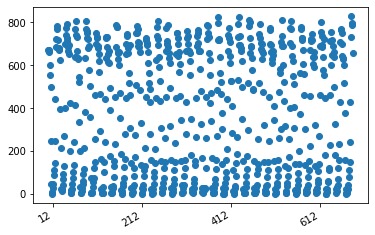

In [661]:
# График обработанной выборки представленный в виде точек
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))
plt.scatter(X_test,df1.Sm)
plt.gcf().autofmt_xdate()
plt.show()

In [677]:
# Введем параметры
s_kerns = ['linear', 'rbf', 'sigmoid']
s_gammas  = [0.01,0.05,0.1]
s_nu      = [0.5, 0.1, 0.05, 0.01]

alogs   = ['auto', 'ball_tree', 'kd_tree', 'brute']
neig    = [2,3,4]
filters = [25,30]
eps     = [0.05,0.1,0.3,0.5]

n_estimators  = [20,40,50,100]
max_samples   = ['auto']
contamination = [0.01,0.05]



In [671]:
# Начнем подбор параметров для одноклассового SVM
num = 0.
ga = [s_kerns[0],s_gammas[0], s_nu[0],0]
for k in s_kerns:
    for gm in s_gammas:
        for nus in s_nu:
            s_model = svm.OneClassSVM( kernel= k, gamma= gm, nu=nus)
            s_model.fit(np.array(df1['Sm']).reshape(-1,1))
            o = pd.Series(s_model.predict(np.array(df1['Sm']).reshape(-1,1))).map({1: False, -1: True})
            nu = o[o == True].size / o.size
            if nu > num and nu < 0.5:
                num = nu
                ga[0] = k
                ga[1] = gm
                ga[2] = nus
                ga[3] = nu
print("Оптимальные подобранные значения")
print("Ядрная функция:",ga[0])
print("Значение гамма:",ga[1])
print("Значние  nu:   ",ga[2])
print("Доля аномалий: ",ga[3])

Оптимальные подобранные значения
Ядрная функция: rbf
Значение гамма: 0.05
Значние  nu:    0.01
Доля аномалий:  0.39212827988338195


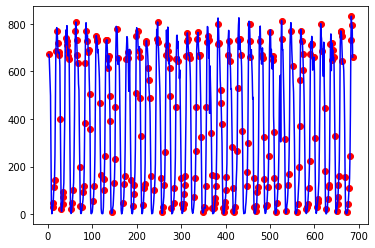

In [672]:
# Результат работы SVM
outputer(svm.OneClassSVM( kernel= ga[0], gamma= ga[1], nu=ga[2]),g,df1)

Оптимальные подобранные значения
Число соседей:              3
Выбранный алгоритм:         auto
Значение границы дальности: 25
Граница доли аномалий:      0.05
Доля аномалий:              0.04227405247813411


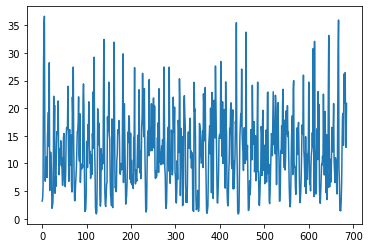

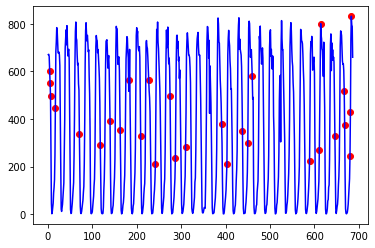

Оптимальные подобранные значения
Число соседей:              4
Выбранный алгоритм:         auto
Значение границы дальности: 30
Граница доли аномалий:      0.1
Доля аномалий:              0.052478134110787174


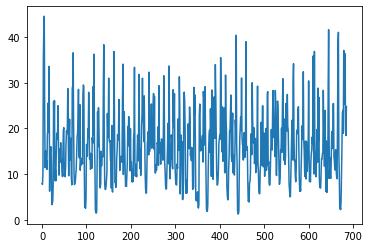

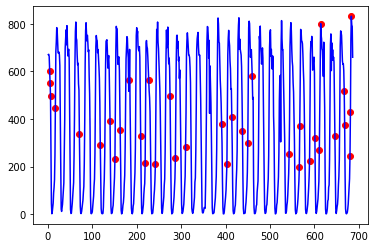

Оптимальные подобранные значения
Число соседей:              4
Выбранный алгоритм:         auto
Значение границы дальности: 25
Граница доли аномалий:      0.3
Доля аномалий:              0.13411078717201166


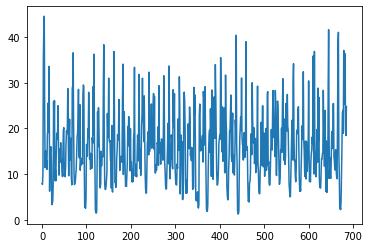

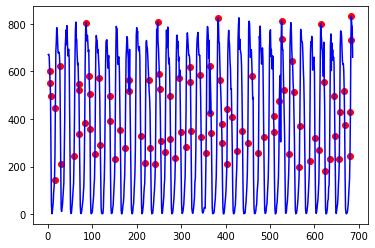

Оптимальные подобранные значения
Число соседей:              2
Выбранный алгоритм:         auto
Значение границы дальности: 25
Граница доли аномалий:      0.5
Доля аномалий:              0.004373177842565598


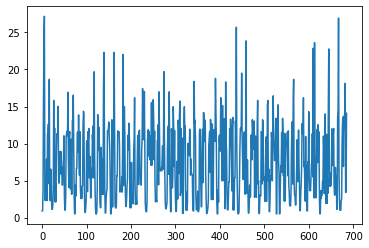

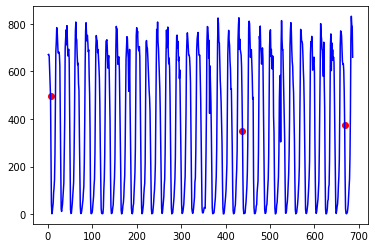

In [682]:
# Начнем подбор параметров для метода ближайших соседей
# Здесь так же введем дополнительный параметр определяющий возможную долю аномалий

# Метод работает очевидным образом: мы обнаруживаем точки набиболее удаленные от соседей
num = 0
for e in eps:
    ga = [neig[0],alogs[0], filters[0],e,0]
    r = g.values
    for al in alogs:
        for nei in neig:
            for fi in filters:
                
                nbrs = NearestNeighbors(n_neighbors = nei, algorithm = al)
                nbrs.fit(r)
                distances, indexes = nbrs.kneighbors(r)
                outlier_index = np.array(distances.mean(axis = 1) > fi)
                nu = outlier_index[outlier_index == True].size / outlier_index.size
                
                if (num < nu) and (e > nu):
                    num = nu
                    ga[0] = nei
                    ga[1] = al
                    ga[2] = fi
                    ga[3] = e
                    ga[4] = nu
    
    nbrs = NearestNeighbors(n_neighbors = ga[0], algorithm=ga[1])
    nbrs.fit(r)
    distances, indexes = nbrs.kneighbors(r)
    outlier_index = np.array(distances.mean(axis = 1) > ga[2])
    
    ga[4] = outlier_index[outlier_index == True].size / outlier_index.size
    
    print("Оптимальные подобранные значения")
    print("Число соседей:             ",ga[0])
    print("Выбранный алгоритм:        ",ga[1])
    print("Значение границы дальности:",ga[2])
    print("Граница доли аномалий:     ",ga[3])
    print("Доля аномалий:             ",ga[4])
    
    
    plt.plot(distances.mean(axis =1))
    plt.show()
    
    plt.plot(g['o'], g['i'], color = "b")
    outlier_values = g.iloc[outlier_index]
    plt.scatter(outlier_values["o"], outlier_values["i"], color = "r")
    plt.show()

In [681]:
num = 0.
ga = [s_kerns[0],s_gammas[0], s_nu[0],0]
for k in n_estimators:
    for gm in max_samples:
        for nus in contamination:
            i_model = IsolationForest( n_estimators= k, max_samples= gm, contamination=nus)
            i_model.fit(np.array(df1['Sm']).reshape(-1,1))
            
            distances = i_model.decision_function(np.array(df1['Sm']).reshape(-1,1))
            anom      = i_model.predict(np.array(df1['Sm']).reshape(-1,1))
            
            anomal = df1[anom == -1]
            
            nu = len(anomal) / len(df1)
            if nu > num and nu < 0.5:
                num = nu
                ga[0] = k
                ga[1] = gm
                ga[2] = nus
                ga[3] = nu
print("Оптимальные подобранные значения")
print("n_estimators:   ",ga[0])
print("Кол-во выборок: ",ga[1])
print("Загрязненность: ",ga[2])
print("Доля аномалий:  ",ga[3])

Оптимальные подобранные значения
n_estimators:    20
Кол-во выборок:  auto
Загрязненность:  0.05
Доля аномалий:   0.05102040816326531


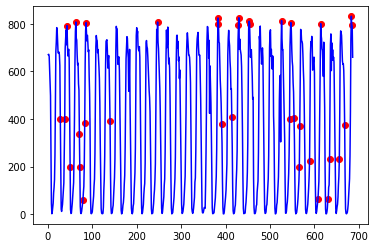

In [679]:
outputer(IsolationForest( n_estimators= ga[0], max_samples= ga[1], contamination=ga[2]), g, df1)

#### Вывод: рассмотрев все графики мы обнаружим, что наиболее точно себя повел последний из выбранных нами методов. Тому есть вполне очевидное объяснение, что SVM хорошо ведет себя при достаточно небольшом наборе данных (здесь помогло уменьшее изначальной выборки). Так же очевидно, что метод Изолированного леса повел себя лучше  ввиду того простого факта, что он как раз-таки и специализируется на поиске аномалий. Ведет он себя лучшем, чем  метода ближайших соседей с параметрами Оптимальные подобранные значения 4, auto, 25, 0.3, ибо тот бракует почти десятую часть выборки.

##### Мораль: свой выбор я оставляю за методом Изолированного леса

## Проверка статистических гипотиз

Последнее, что я бы хотел рассмотреть это подтверждение или же опровержение различных статистических гипотез, что в часть работы не обязано входить, но рассмотреть все же стоит

In [683]:
# Тест Шапиро
st, p = scipy.stats.shapiro(df1.Sm)
if p > 0.05:
    print('Probably Gussian or Normal')
else:
    print('Probably not Gussian or Normal')

Probably not Gussian or Normal


In [685]:
# Тест Харке — Бера
st, p = scipy.stats.jarque_bera(df1.Sm)
if p > 0.05:
    print('Probably Gussian or Normal')
else:
    print('Probably not Gussian or Normal')

Probably not Gussian or Normal


In [687]:
# Тест Колмогорова-Смирнова
st, p = scipy.stats.kstest(df1.Sm,'norm')
if p > 0.05:
    print('Probably Gussian or Normal')
else:
    print('It is\'not Normal')

It is'not Normal


Вывод: ряд явно не обладает нормальным или гаусовским распределением.

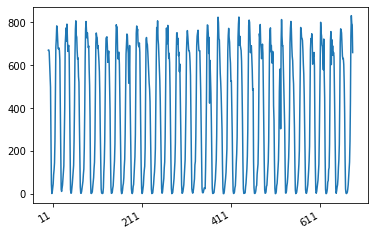

In [691]:
# Наблюдая за графиком можно заметить со стороны,
# что последний обладает некой сезонностью
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))
plt.plot(df1.Sm)
plt.gcf().autofmt_xdate()
plt.show()

In [625]:
from statsmodels.tsa.stattools import acf, adfuller
import statsmodels.api as sm

In [688]:
# Воспользуемся Тестом Дики — Фуллера 
# дабы проверить стационарность ряда
p_value = adfuller(df1.Sm)
print ('adf: ', p_value[0]) 
print ('p-value: ', p_value[1])
print ('Critical values: ', p_value[4])
if p_value[0]> p_value[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -6.283075150441276
p-value:  3.755004551283147e-08
Critical values:  {'1%': -3.4402217619947315, '5%': -2.865896026254794, '10%': -2.5690897354287974}
единичных корней нет, ряд стационарен


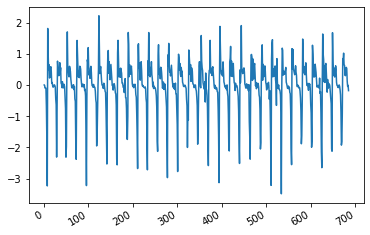

In [693]:
# Продифференцированный нами исходный ряд
# здесь также можно наблюдать сезонность значений
# Напомним, что данным нам ряд мы не дифференцировали,
# ибо уже был стационарен.
df.Sm.replace(0, 0.01)
df1['Smlog'] = np.log(df1.Sm)
df1['SmlogDiff'] = df1.Smlog - df1.Smlog.shift(1)
plt.plot(df1['SmlogDiff'] )
plt.gcf().autofmt_xdate()
plt.show()

## Рекурсия

Косвенно затроним еще вопрос рекурсии. Т.к. наш ряд стационарен: мы можем предугадать его дальнейшие значения. Для этого воспользуемся рекурсией SARIMAX, подобрав для нее наиболее подходящие значения.

In [631]:
from itertools import product
from tqdm import tqdm

In [630]:
d=1
D=1
qs = range(1, 4)
Qs = range(1, 2)
ps = range(1, 4)
Ps = range(2, 4)

In [632]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
results = []
best_aic = float("inf")
for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.Sm, 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [18:35<00:00, 61.98s/it]


In [53]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
16  (3, 3, 2, 1)  27561.398319
17  (3, 3, 3, 1)  27565.002910
10  (2, 3, 2, 1)  27585.240981
4   (1, 3, 2, 1)  27604.590092
14  (3, 2, 2, 1)  27707.052477


In [694]:
def mape(x,y):
    mask = x != 0
    return (np.fabs(x-y)/x)[mask].mean()

In [697]:
df3 = pd.DataFrame()
g,k = [],[]
for i in range(0,math.ceil(len(df1)*0.8)):
    g.append(df1.Sm[i])
    k.append(df1.Time[i])
df3['Time'] = k
df3['Sm']   = g

In [ ]:
model = sm.tsa.statespace.SARIMAX(
            df3.Sm, 
            order=(3,3,2), 
            seasonal_order=(3,3,2, math.ceil(len(df1)*0.8))
        ).fit(disp=-1)